# LSTM (Long Short Term Memory)

There is a branch of Deep Learning that is dedicated to processing time series. These deep Nets are **Recursive Neural Nets (RNNs)**. LSTMs are one of the few types of RNNs that are available. Gated Recurent Units (GRUs) are the other type of popular RNNs.

This is an illustration from http://colah.github.io/posts/2015-08-Understanding-LSTMs/ (A highly recommended read)

![RNNs](../RNN-unrolled.png)

### Futher Reading
1. http://karpathy.github.io/2015/05/21/rnn-effectiveness/
2. http://colah.github.io/posts/2015-08-Understanding-LSTMs/

### YouTube Video
1. https://www.youtube.com/watch?v=ywinX5wgdEU
2. https://www.youtube.com/watch?v=e1pEIYVOtqc

Pros:
- Really powerful pattern recognition system for time series

Cons:
- Cannot deal with missing time steps.
- Time steps must be discretised and not continuous.

![trump](../images/trump.jpg)

In [2]:
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/e1pEIYVOtqc?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, LSTM, Embedding, TimeDistributed
from keras.models import load_model, model_from_json

Using TensorFlow backend.


In [2]:
def chr2val(ch):
    ch = ch.lower()
    if ch.isalpha():
        return 1 + (ord(ch) - ord('a'))
    else:
        return 0
    
def val2chr(v):
    if v == 0:
        return ' '
    else:
        return chr(ord('a') + v - 1)

In [24]:
df = pd.read_csv('trump.csv')
df = df[df.is_retweet=='false']
df.text = df.text.str.lower()
df.text = df.text.str.replace(r'http[\w:/\.]+','') # remove urls
df.text = df.text.str.replace(r'[^!\'"#$%&\()*+,-./:;<=>?@_’`{|}~\w\s]',' ') #remove everything but characters and punctuation
df.text = df.text.str.replace(r'\s\s+',' ') #replace multple white space with a single one
df = df[[len(t)<180 for t in df.text.values]]
df = df[[len(t)>50 for t in df.text.values]]
df.head()

,source,text,created_at,favorite_count,is_retweet,id_str
0,Twitter for iPhone,i think senator blumenthal should take a nice ...,08-07-2017 20:48:54,61446,false,8.946617e+17
1,Twitter for iPhone,how much longer will the failing nytimes with ...,08-07-2017 20:39:46,42235,false,8.946594e+17
2,Twitter for iPhone,the fake news media will not talk about the im...,08-07-2017 20:15:18,45050,false,8.946532e+17
4,Twitter for iPhone,on #purpleheartday i thank all the brave men a...,08-07-2017 18:03:42,48472,false,8.946201e+17
5,Twitter for iPhone,...conquests how brave he was and it was all a...,08-07-2017 12:01:20,59253,false,8.945289e+17


In [25]:
df.shape

(23938, 6)

Remove emojis, flags etc from tweets. Also notice how I have used `[::-1]` to indicate that I want the tweets in chrnological order.

In [26]:
trump_tweets = [text for text in df.text.values[::-1]]
trump_tweets[:5]

['be sure to tune in and watch donald trump on late night with david letterman as he presents the top ten list tonight!',
 'donald trump will be appearing on the view tomorrow morning to discuss celebrity apprentice and his new book think like a champion!',
 'donald trump reads top ten financial tips on late show with david letterman:  - very funny!',
 'new blog post: celebrity apprentice finale and lessons learned along the way: ',
 'my persona will never be that of a wallflower - i’d rather build walls than cling to them --donald j. trump']

Create a dictionary to convert letters to numbers and vice versa.

In [27]:
all_tweets = ''.join(trump_tweets)
char2int = dict(zip(set(all_tweets), range(len(set(all_tweets)))))
char2int['<END>'] = len(char2int)
char2int['<GO>'] = len(char2int)
char2int['<PAD>'] = len(char2int)
int2char = dict(zip(char2int.values(), char2int.keys()))

In [30]:
text_num = [[char2int['<GO>']]+[char2int[c] for c in tweet]+ [char2int['<END>']] for tweet in trump_tweets]

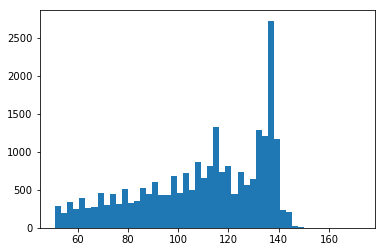

In [31]:
plt.hist([len(t) for t in trump_tweets],50)
plt.show()

In [32]:
# Concatenate all the tweets
int_text = []
for t in text_num:
    int_text += t

len_vocab = len(char2int)
sentence_len = 40
# n_chars = len(text_num)//sentence_len*sentence_len
num_chunks = len(text_num)-sentence_len

def get_batches(int_text, batch_size, seq_length):
    """
    Return batches of input and target
    :param int_text: Text with the words replaced by their ids
    :param batch_size: The size of batch
    :param seq_length: The length of sequence
    :return: Batches as a Numpy array
    """
    
    slice_size = batch_size * seq_length
    n_batches = len(int_text) // slice_size
    x = int_text[: n_batches*slice_size]
    y = int_text[1: n_batches*slice_size + 1]

    x = np.split(np.reshape(x,(batch_size,-1)),n_batches,1)
    y = np.split(np.reshape(y,(batch_size,-1)),n_batches,1)
    
    x = np.vstack(x)
    y = np.vstack(y)
    y = y.reshape(y.shape+(1,))
    return x, y

batch_size = 128
x, y = get_batches(int_text, batch_size, sentence_len)

Notice what the `get_batches` function looks like.

In [33]:
np.arange(16).reshape((-1,4))

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [32]:
np.arange(1,17)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [30]:
x1, y1 = get_batches(np.arange(17), 2,4)
x1

array([[ 0,  1,  2,  3],
       [ 8,  9, 10, 11],
       [ 4,  5,  6,  7],
       [12, 13, 14, 15]])

## Many to Many LSTM

In [34]:
model = Sequential()
model.add(Embedding(len_vocab, 16, batch_size=batch_size)) # , batch_size=batch_size
model.add(LSTM(64, return_sequences=True, stateful=True)) # , stateful=True
model.add(LSTM(64, return_sequences=True, stateful=True))
model.add(TimeDistributed(Dense(len_vocab, activation='softmax')))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (128, None, 16)           1360      
_________________________________________________________________
lstm_3 (LSTM)                (128, None, 64)           20736     
_________________________________________________________________
lstm_4 (LSTM)                (128, None, 64)           33024     
_________________________________________________________________
time_distributed_2 (TimeDist (128, None, 85)           5525      
Total params: 60,645.0
Trainable params: 60,645
Non-trainable params: 0.0
_________________________________________________________________


Pay special attention to how the probabilites are taken. p is of shape `(1, sequence_len, len(char2int))` where len(char2int) is the number of available characters. The 1 is there because we are only predicting one feature, `y`. We are only concerned about the last prediction probability of the sequence. This is due to the fact that all other letters have already been appended. Hence we predict a letter from the distribution `p[0][-1]`.

Why did we keep appending to the sequence and predicting? Why not use simply the last letter. If we were to do this, we would lose information that comes from the previous letter via the hidden state and cell memory. Keep in mind that each LSTM unit has 3 inputs, the x, the hidden state, and the cell memory. 

Also important to notice that the Cell Memory is not used in connecting to the Dense layer, only the hidden state.

### Stateful training:

What happens when `stateful=True` is that the last cell memory state computed at the i-th example in the n-th batch gets passed on to i-th sample in the n+1-th batch. This is one way of _seeing_ patterns beyond the sentence length specified. Which in this case is 40.

#### Note
1. Really important that when I `fit` the model I set `shuffle=False` when training stateful models.
2. I need to copy the weights to a non-stateful model because the original only takes `batch_size` inputs at a time. Whereas, I only want to predict one character at a time.

In [41]:
model2 = Sequential()
model2.add(Embedding(len_vocab, 16)) # , batch_size=batch_size
model2.add(LSTM(64, return_sequences=True)) # , stateful=True
model2.add(LSTM(64, return_sequences=True))
model2.add(TimeDistributed(Dense(len_vocab, activation='softmax')))

def generate_sentence(model, sentence_len):
    sentence = []
    letter = [char2int['<GO>']] #choose a random letter
    for i in range(sentence_len):
        sentence.append(int2char[letter[-1]])
        model2.set_weights(model.get_weights())
        p = model2.predict(np.array(letter)[None,:])
        letter.append(np.random.choice(len(char2int),1,p=p[0][-1])[0])
    
    return ''.join(sentence)

In [38]:
n_epochs = 50
for i in range(n_epochs+1):
    if i%5==0:
        sentence = generate_sentence(model, 100)
        print(sentence)
        print('='*100)
        v = 1
    if i!=n_epochs:
        model.fit(x,y, batch_size=batch_size, epochs=1, shuffle=False, verbose=v)
        model.reset_states()
        v = 0

<GO>
1/@ıbp. pet ocl  u1pn<END><GO><GO>grbaltlrdbt marapueanos taánaaoe @ratodec.ruto- pfe eamfodhyt ia. bpaldewr
Epoch 1/1
66560/66560 [==============================] - 111s - loss: 2.5847   
<GO>.!- <GO>whingment do3% be @banemviqrush: dotarnion.<END><GO>hill diir. baden" reations bimman in @realdonactr
Epoch 1/1
66560/66560 [==============================] - 119s - loss: 1.9990   
<GO>"! @myjinnalnjats: @reealebbparriu<END><GO>bod exbissed great!<END><GO>@erutbzart: i duserest got!u deald reangne
Epoch 1/1
66560/66560 [==============================] - 104s - loss: 1.8533   
<GO><GO>onye right" #debloss chinastivate!<END><GO>@marmervalf: @realdonaldtrump @realdonaldtrump is many had in 
Epoch 1/1
66560/66560 [==============================] - 114s - loss: 1.7786   
<GO> will never newed wid - will filt unfell! @neme not's ambess in @barepelistber the arith 4 milly wo
Epoch 1/1
  256/66560 [..............................] - ETA: 200s - loss: 1.8051

/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:118: UserWarning: Method on_batch_end() is slow compared to the batch update (0.392488). Check your callbacks.
  % delta_t_median)
/root/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:118: UserWarning: Method on_batch_end() is slow compared to the batch update (0.196978). Check your callbacks.
  % delta_t_median)


66560/66560 [==============================] - 110s - loss: 1.7286   
<GO> then by to @foxnews!<END><GO>gold clue onlini nerdities be is lost plepit will i cangon storogts. us this
Epoch 1/1
66560/66560 [==============================] - 98s - loss: 1.6912    
<GO>cnank tourstes the news. be ragelil can valls at it that menting who wants ny's going of for for to
Epoch 1/1
66560/66560 [==============================] - 105s - loss: 1.6631   
<GO>attodays ware @mbh starmentbe you-ene are ever with mitt open stmentuled and i housnist are  <END><GO> my 
Epoch 1/1
66560/66560 [==============================] - 105s - loss: 1.6400   
<GO>min balm!<END><GO>@am584  tremince have angeriet’s #donitechug for me insredent!<END><GO>@moon_ter: @newyontrrud 
Epoch 1/1
66560/66560 [==============================] - 111s - loss: 1.6217   
<GO>arelaces into kay for i kavity that's kastests i intervied you hand their never cares--he mind gavi
Epoch 1/1
66560/66560 [==============================] - 93s -

In [43]:
n_epochs = 30
for i in range(n_epochs+1):
    if i%5==0:
        sentence = generate_sentence(model, 100)
        print(sentence)
        print('='*100)
        v = 1
    if i!=n_epochs:
        model.fit(x,y, batch_size=batch_size, epochs=1, shuffle=False, verbose=v)
        model.reset_states()
        v = 0

<GO>mm thinks @beinkintard.  polio deliveds.<END><GO>@jenaorisemila: @realdanasura   i will resting release! g
Epoch 1/1
66560/66560 [==============================] - 81s - loss: 1.5906    
<GO><END><GO>efstinood-thwe see shout  .@endilaryone @esorropsec.is. hosted nowinutionais beremespess leader t
Epoch 1/1
66560/66560 [==============================] - 101s - loss: 1.5798   
<GO>-&ttrump her your foin never they're vie because can't beaters problems of durmy for put by r shour
Epoch 1/1
66560/66560 [==============================] - 101s - loss: 1.5706   
<GO>mumm2p @foxnewderated<END><GO>poleds..... is.<END><GO>quick barning twee who need o negether mitt at of teldmin! 
Epoch 1/1
66560/66560 [==============================] - 99s - loss: 1.5623    
<GO>erear god an if instoiense for my fars!<END><GO>jiaded what be a greatest nomight of my @bofhaptroskec vot
Epoch 1/1
66560/66560 [==============================] - 104s - loss: 1.5549   
<GO>6<GO>sterry gong about the donoys like a 

In [44]:
for j in range(10):
    sentence = generate_sentence(model, 100)
    print(sentence)
    print('='*100)

<GO>8<GO>bai condire @mittromney<END><GO>id more in the majoriful!<END><GO>geored this ressious &amp; worth-leaking me<END><GO>
<GO><END>61.; use stngorfur.<END><GO>thank you bring failed for on 48 for patter<END><GO>@tyoupcortani-   will be good at
<GO>6<GO>i q.. <END><GO>itona is both proobanf invised hin.<END><GO>qoldrew confiden statrazy etheric.. new with priwide
<GO>e nevotu something proshious will sthere.<END><GO>great i jackets anoscorday.<END><GO>very concord for nice! come
<GO>#tutlamprices in weicle fuborselo's governed anceir ffratel...  never saying invelueters don't doin
<GO>5<GO>stust to kufsline for hnited and celebrity watch after havo stet everybt wrate done car-i to peri
<GO>:. "erusheek lave the story in the drodia in taking waiting foot a man snitiqutes for the man busis
<GO>6<GO>bl. @realdonaldtrump linning. he estafus to for a states and devansel we nominal rynese he contas
<GO>6<GO>stust!<END><GO>@wxejjonaticore: well rating about - an eligason #newssmit for yo

In [138]:
with open('model_struct.json','w') as f:
    f.write(model.to_json())
model.save_weights('model_weights.h5')
model.save('model.h5')

In [34]:
# if not 'model' in vars():
# #     model = load_model('model.h5') # This doesn't seem to work for some odd reason
#     with open('model_struct.json','r') as f:
#         model = model_from_json(f.read())
#     model.load_weights('model_weights.h5')

In [19]:
model = Sequential()
model.add(Embedding(len_vocab, 64)) # , batch_size=batch_size
model.add(LSTM(64, return_sequences=True)) # , stateful=True
model.add(TimeDistributed(Dense(len_vocab, activation='softmax')))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.summary()
model.load_weights('model_weights.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          8512      
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 133)         8645      
Total params: 50,181.0
Trainable params: 50,181
Non-trainable params: 0.0
_________________________________________________________________


### Beam Search

In [28]:
np.unique(np.random.choice(5,3))

array([0, 2, 4])

In [ ]:
def beam_search(seq_len):
    p = model.predict(np.array(letter)[None,:])
    np.unique(np.random.choice(len(char2int),10,p=p[0][-1])[0])